In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np; np.set_printoptions(precision=5,suppress=True)
np.random.seed(0)
from extquadcontrol import dp_infinite, dp_finite, ExtendedQuadratic, FiniteHorizonSystem, FiniteHorizonSystem, AffinePolicy
import matplotlib.pyplot as plt

In [3]:
mu_appl, sigma_appl = (0.001310425697314454, 0.01525792783452506)

In [4]:
n = 2
m = 1
K = 2

P_f = np.zeros((n,n))
q_f = np.zeros(n)
r_f = 0
g_T = [ExtendedQuadratic(P_f,q_f,r_f,np.array([[1,0]]),np.array([0])) for _ in range(2)]


def optimal_execution(gamma_ex, gamma_tr, gamma_imp, mu, sigma, T, N, pliq):
    def sample(t,N):
        r = np.random.lognormal(mu,sigma,size=N)
        A = np.zeros((N,K,n,n))
        A[:,0,0,0] = 1
        A[:,0,1,1] = r
        B = np.zeros((N,K,n,m))
        B[:,0,0,0] = -1
        B[:,0,1,0] = -r*gamma_imp
        c = np.zeros((N,K,n))
        Pi = np.array([
            [1-pliq,0],
            [pliq,1]
        ])
        P = np.array([
            [gamma_ex, 0, 0],
            [0,0,-1],
            [0,-1,gamma_tr]
        ])
        q = np.zeros(n+m)
        r = 0
        g = [[ExtendedQuadratic(P,q,r),
              ExtendedQuadratic(np.eye(n+m),np.zeros(n+m),0,np.array([[1,0,-1]]),np.array([0]))]
             for _ in range(N)]

        return A,B,c,g,Pi

    Vs, Qs, policies = dp_finite(sample, g_T, T, N)
    
    return Vs, Qs, policies, sample
                                                         

In [5]:
# AAPL example

gamma_ex = 1e-4 # dollars / share squared
gamma_tr = 1e-3 # dollars / share squared
gamma_imp = 1e-6 # dollars / share squared

N = 1000
T = 30

mu = mu_appl
sigma = sigma_appl

Vs, Qs, policies, sample = optimal_execution(gamma_ex, gamma_tr, gamma_imp, mu, sigma, T, N, 1e-4)

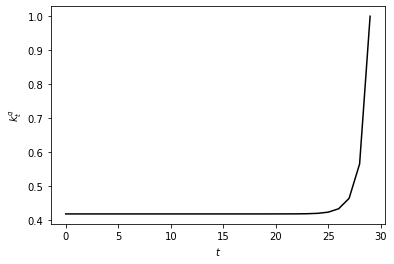

In [6]:
plt.plot([p[0][0][0,0] for p in policies], c='black')
plt.xlabel('$t$')
plt.ylabel('$k_t^q$')
plt.savefig('figs/executionrandom1.pdf')

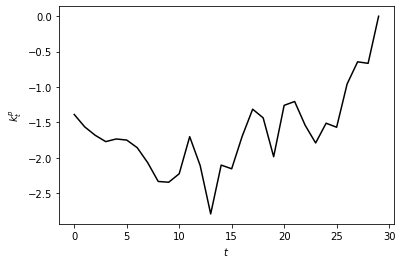

In [7]:
plt.plot([p[0][0][0,1] for p in policies], c='black')
plt.xlabel('$t$')
plt.ylabel('$k_t^p$')
plt.savefig('figs/executionrandom2.pdf')

In [10]:
system = FiniteHorizonSystem(sample,g_T,K)
policy = AffinePolicy(policies)

In [11]:
Xss = []
totals = []
for _ in range(1000):
    Xs, Us, modes, cost = system.simulate(np.array([2000,222]),0,T,policy,0)
    Xss.append(Xs)
    totals.append((np.sum(Xs[:-1,1]*Us[:,0])-np.sum(gamma_tr*Us[:,0])**2))

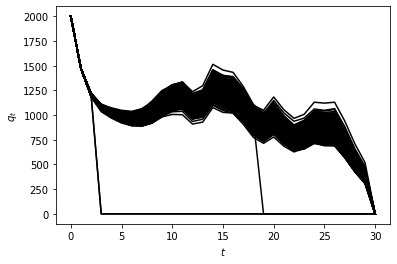

In [12]:
for Xs in Xss:
    plt.plot(np.arange(T+1),Xs[:,0], c='black')
plt.ylabel('$q_t$')
plt.xlabel('$t$')
plt.savefig('figs/executionrandom3.pdf')